# Downloading neccessary libraries

In [1]:
!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade

# Import neccessary libraries

In [2]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches
from kornia.feature import LoFTR
import pandas as pd
from scipy.stats import zscore

# Loading images

In [3]:
img1 = K.io.load_image('images/left.jpg', 
                       K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('images/right.jpg', 
                       K.io.ImageLoadType.RGB32)[None, ...]
print(img1.shape)
print(img2.shape)

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)
print(img1.shape)
print(img2.shape)

torch.Size([1, 3, 1440, 2560])
torch.Size([1, 3, 1440, 2560])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


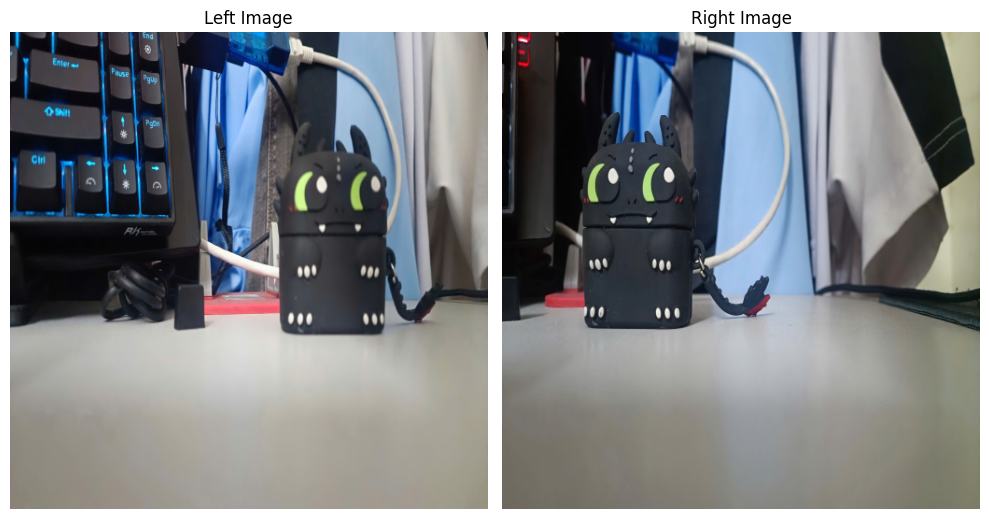

In [4]:
# Squeeze the first dimension
img1_plot = img1.squeeze(0)  # Remove the first dimension
img2_plot = img2.squeeze(0)  # Remove the first dimension

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Display the first image
axes[0].imshow(img1_plot.permute(1, 2, 0))  # Rearrange to (height, width, channels)
axes[0].set_title('Left Image')
axes[0].axis('off')  # Turn off axis

# Display the second image
axes[1].imshow(img2_plot.permute(1, 2, 0))  # Rearrange to (height, width, channels)
axes[1].set_title('Right Image')
axes[1].axis('off')  # Turn off axis

# Show the plot
plt.tight_layout()
plt.show()

# Defines the religion for the object to measure depth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


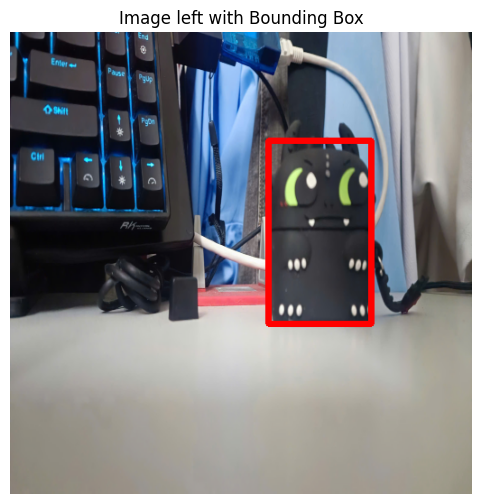

In [5]:
# Convert to NumPy array for OpenCV and Matplotlib compatibility
img1_resized_np = img1.squeeze().permute(1, 2, 0).cpu().numpy()

# Define the bounding box coordinates
x1, y1 = 286, 120
x2, y2 = 400, 323

# Define the rectangle coordinates
top_left = (x1, y1)
bottom_right = (x2, y2)

# Make a copy of the image to draw the rectangle on
img1_with_bbox = img1_resized_np.copy()

# Draw the rectangle (blue color, thickness 2)
cv2.rectangle(img1_with_bbox, top_left, bottom_right, (255, 0, 0), 5)

# Plot the image with the bounding box
plt.figure(figsize=(6, 6))
plt.imshow(img1_with_bbox)
plt.title('Image left with Bounding Box')
plt.axis('off')  # Turn off axis
plt.show()

# Initialize the model using for matching

In [6]:
matcher = LoFTR(pretrained="outdoor")

In [7]:
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

# Matching Features

In [8]:
with torch.inference_mode():
    correspondences = matcher(input_dict)

# Clean up the correnspondences using RANSAC

In [9]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, 
                                     cv2.USAC_MAGSAC, 
                                     0.5, 0.999, 100000)
inliers = inliers > 0

In [10]:
mkpts0[0:3]  # features 0-2 in image 1

array([[168.,  16.],
       [416.,  16.],
       [168.,  24.]], dtype=float32)

In [11]:
mkpts1[0:3]  # matched features to 0-2 of the image 1 on the image 2

array([[ 39.002956,  15.646756],
       [320.7407  ,  24.878159],
       [ 39.519276,  24.730618]], dtype=float32)

# Display all the possible matched features

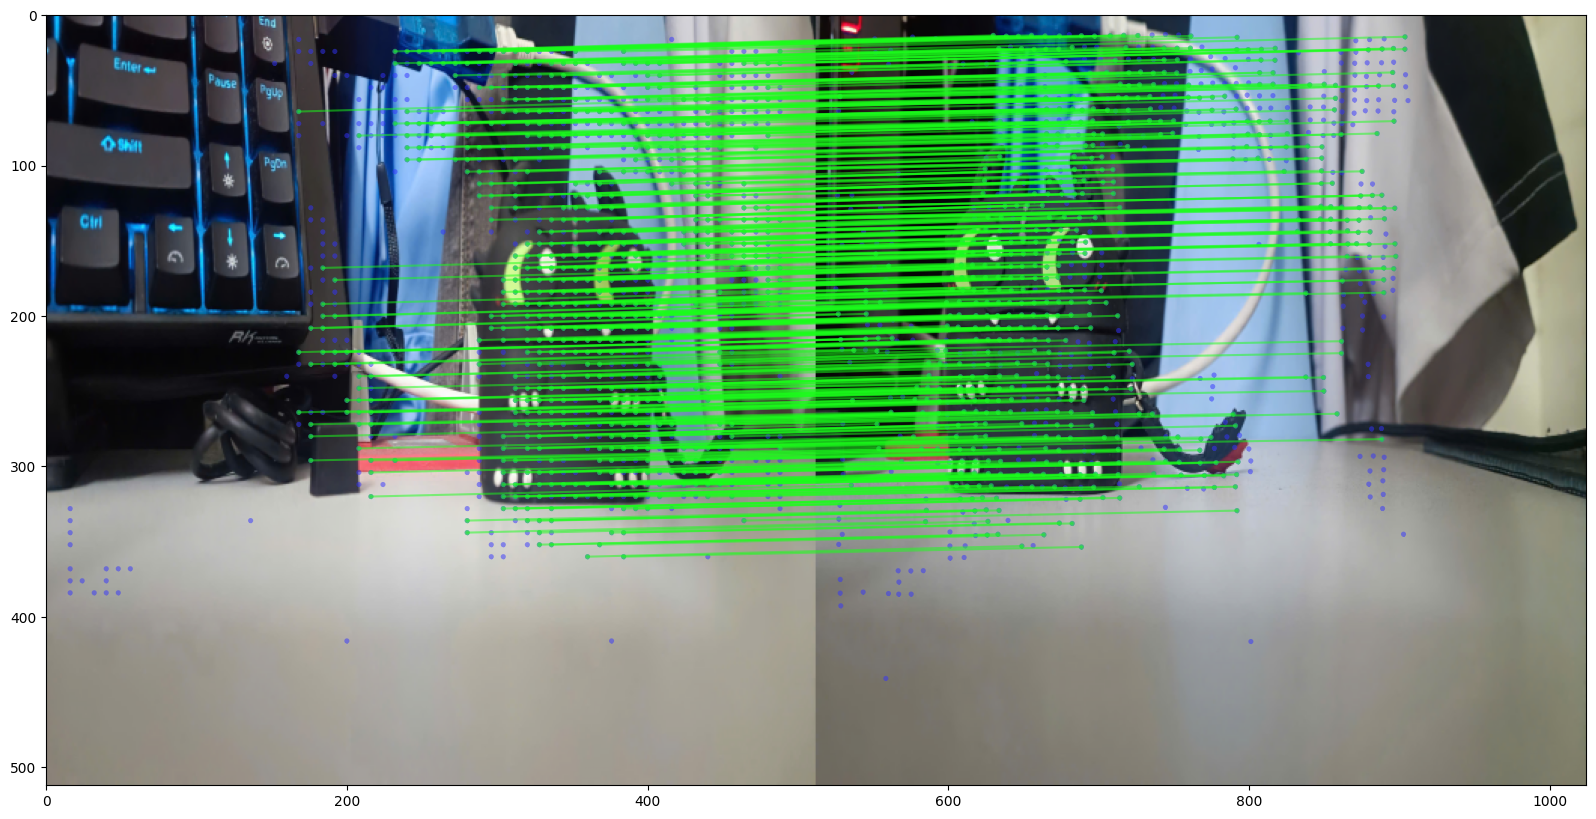

In [12]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)

# Filter the features which are in the bbox

In [13]:
# Initiate the bbox coords
bbox_x1, bbox_y1 = 286, 120
bbox_x2, bbox_y2 = 400, 323

distance = []
fx = 1887.5281503864207
b = 10 #cm

# Save matched keypoint coordinates to a text file, filtering by bounding box
with open('result.txt', 'w') as f:
    for idx in range(0, len(mkpts0), 1):
        x0, y0 = mkpts0[idx]  # Coordinates from the first image
        x1, y1 = mkpts1[idx]  # Coordinates from the second image
        if bbox_x1 < x0 < bbox_x2 and bbox_y1 < y0 < bbox_y2:
            distance.append(b * fx / (5 * (x0 - x1)))
            # f.write(f"Keypoint {idx}: Image 1: ({x0:.2f}, {y0:.2f}), Image 2: ({x1:.2f}, {y1:.2f})\n")
            f.write(f"{idx},{x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}\n")
            
print('Saved')

Saved


# Check the location of the coords

In [14]:
with open('result.txt', 'r') as file:
    coords = file.read()

coords = coords.split('\n')
coords.remove('')

print(len(coords))
coords[0]

273


'305,296.00,128.00,197.71,118.52'

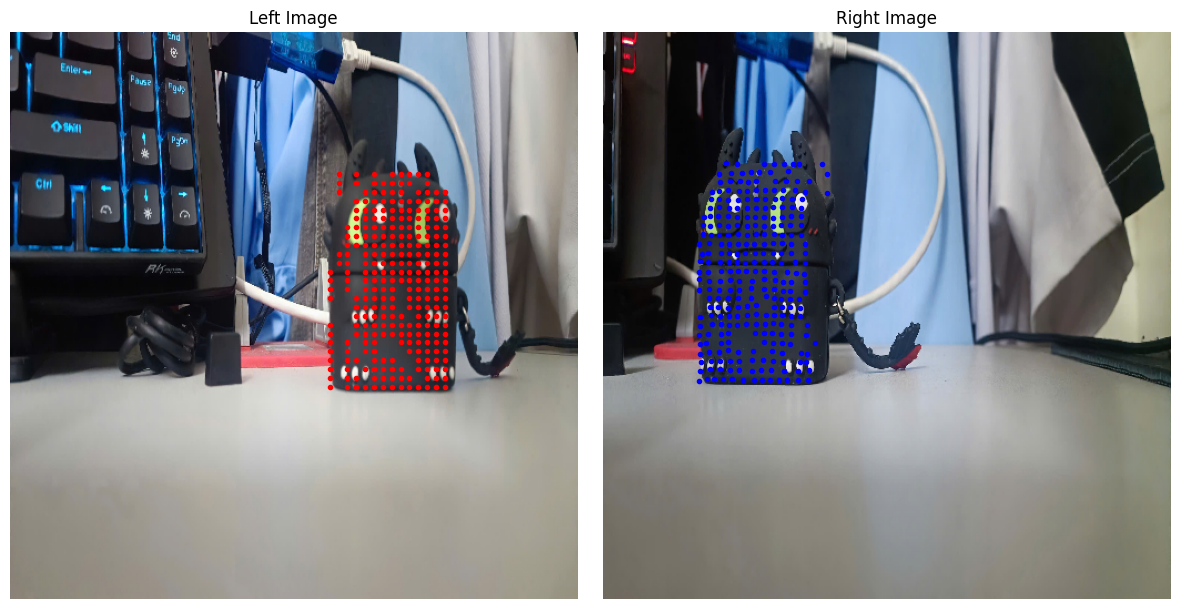

In [15]:
# Load the images (make sure to provide the correct paths)
img1 = cv2.imread('images/left.jpg')  # Left image
img2 = cv2.imread('images/right.jpg')  # Right image

# Resize images to (512, 512)
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.resize(img2, (512, 512))

# Convert BGR to RGB (OpenCV uses BGR by default)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

matched_keypoints = []
for coord in coords:
    idx, ul, vl, ur, vr = list(map(float, coord.split(',')))
    matched_keypoints.append((idx, (ul, vl), (ur, vr)))
    

# Plot the images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image
axes[0].imshow(img1)
axes[0].set_title('Left Image')
axes[0].axis('off')  # Turn off axis

# Display the second image
axes[1].imshow(img2)
axes[1].set_title('Right Image')
axes[1].axis('off')  # Turn off axis

# Plot matched keypoints
for keypoint, (x1, y1), (x2, y2) in matched_keypoints:
    # Plot on Image 1
    axes[0].plot(x1, y1, 'r.')  # Red circle for keypoint in Image 1
    # axes[0].text(x1, y1, str(keypoint), color='white', fontsize=.05)

    # Plot on Image 2
    axes[1].plot(x2, y2, 'b.')  # Blue circle for keypoint in Image 2
    # axes[1].text(x2, y2, str(keypoint), color='white', fontsize=.05)

# Show the plot
plt.tight_layout()
plt.show()

# Check the distances calculated using all the matching points

In [16]:
df = pd.DataFrame({
    'distance': distance
})

df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,273.0,18.040508,2.304135,17.436655,17.580426,17.651943,17.972495,40.158674


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7., 180.,  47.,  17.,
          4.,  12.,   3.,   0.,   0.]),
 array([15.    , 15.3125, 15.625 , 15.9375, 16.25  , 16.5625, 16.875 ,
        17.1875, 17.5   , 17.8125, 18.125 , 18.4375, 18.75  , 19.0625,
        19.375 , 19.6875, 20.    ]),
 <BarContainer object of 16 artists>)

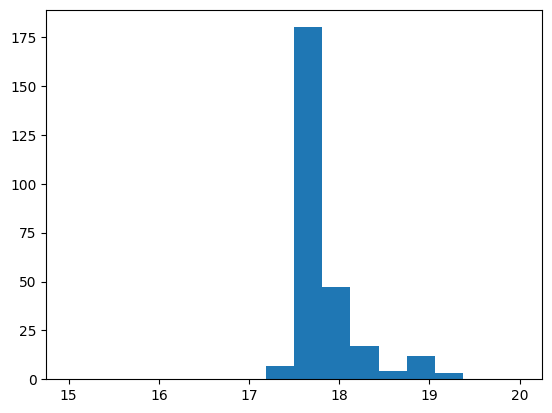

In [28]:
plt.hist(df['distance'], range=(15, 20), bins=int(len(df) ** .5))

<Axes: ylabel='Frequency'>

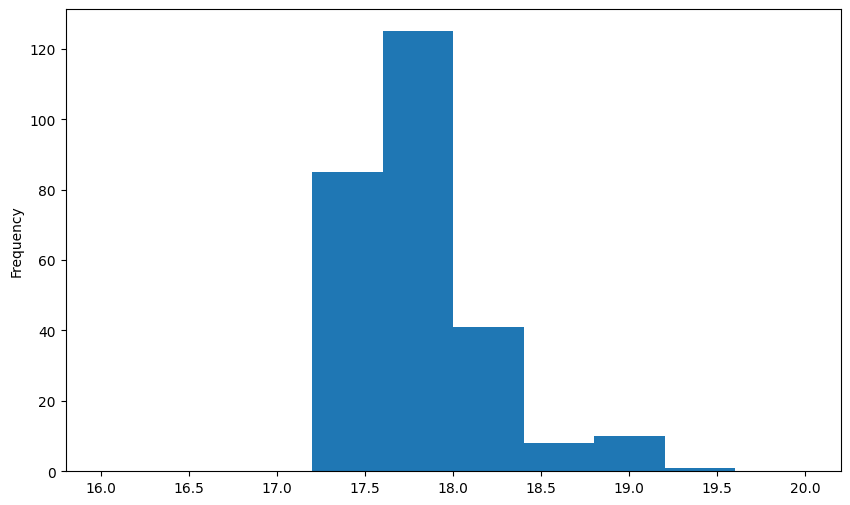

In [27]:
plt.figure(figsize=(10, 6))
df['distance'].plot.hist(bins=10, range=(16, 20))

# Filtering outliers using Z-score
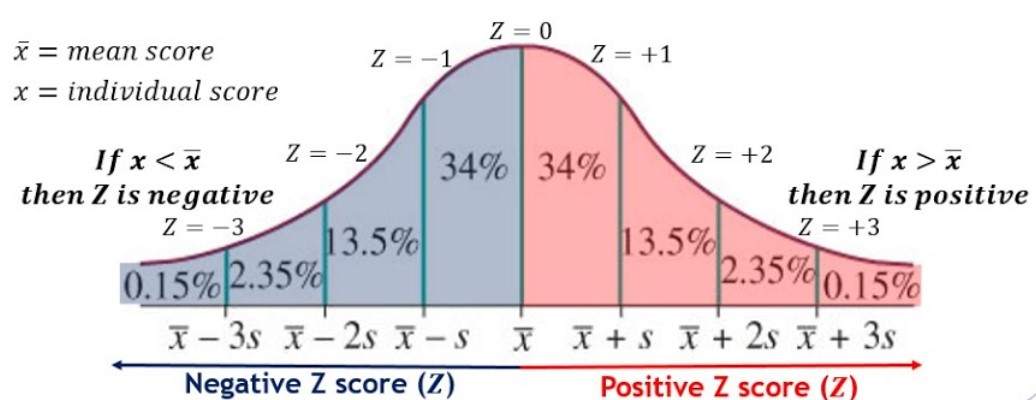

In [18]:
# Calculate Z-scores
z_scores = zscore(df, axis=0)

# Define a threshold for identifying outliers
threshold = 3

# Filter the data to remove outliers
filtered_data = df[(np.abs(z_scores) < threshold).all(axis=1)]

filtered_data.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,270.0,17.801258,0.363889,17.436655,17.580339,17.649475,17.966237,19.245739


# Result

In [19]:
print('The distance to the object is:', df['distance'].mean())

The distance to the object is: 18.04050834912725
